# Implementación del método de Newton para la optimización de tratamientos de radioterapia de intensidad modulada (IMRT)
### Andrés Camilo Sevilla Moreno
1 de junio de 2020


In [1]:
# Import sparse module from SciPy package 
from scipy import sparse
# Import csr_matrix function from SciPy package
from scipy.sparse import csr_matrix
#Import inv operation from from SciPy package
from scipy.sparse.linalg import inv
# Import NumPy module
import numpy as np
# Import MatPlotLib module
import matplotlib as mpl
# Import PyPlot function from NumPy
import matplotlib.pyplot as plt
# Import Image function from PIL
from PIL import Image

In [2]:
def getStructureFromName(structureName):
    for i in range(np.size(structures,0)):
        if(structureName==structures[i][3]):
            return structures[i]
        
def getObjetivesFromStructure(structure):
    objetivesFromStructure=[]
    for i in range(np.size(objetives,0)):
        if(structure[0]==objetives[i][0]):
            objetivesFromStructure.append(objetives[i])
    return objetivesFromStructure

def getStructureFromObjetive(objetive):
    for i in range(np.size(structures,0)):
        if(objetive[0]==structures[i][0]):
            return structures[i]

# Define PTV dose deviation function for x intensity vector
def dObjetives(x,scenario):
    dObjetives = []
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        if(objetives[i][1]=="squared_deviation"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2]))
        if(objetives[i][1]=="squared_overdosing"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2])*(Dij[scenario]*x>objetives[i][2]))
        if(objetives[i][1]=="squared_underdosing"):
            dObjetives.append(T[structureIndex]*(Dij[scenario]*x-objetives[i][2])*(Dij[scenario]*x<objetives[i][2]))
    return dObjetives

# Define objective function
def F(x,scenario):
    F = 0
    for i in range(np.size(objetives,0)):
        F+=objetives[i][3]*pow(dObjetives(x,scenario)[i],2).sum()
    return F/nVoxels

# Define objective function
def F_robust(x):
    F = 0
    for j in range(np.size(scenarios,0)):
        for i in range(np.size(objetives,0)):
            F+=objetives[i][3]*pow(dObjetives(x,j)[i],2).sum()
    return F/nVoxels/np.size(scenarios,0)

In [3]:
def NablaF(x,scenario):
    NablaF = 0
    for i in range(np.size(objetives,0)):
        NablaF+=objetives[i][3]*Dij[scenario].transpose()*dObjetives(x,scenario)[i]
    return NablaF

def NablaF_robust(x):
    NablaF = 0
    for j in range(np.size(scenarios,0)):
        for i in range(np.size(objetives,0)):
            NablaF+=objetives[i][3]*Dij[j].transpose()*dObjetives(x,j)[i]
    return NablaF

def Nabla2F(x,scenario):
    Nabla2 = 0
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        Nabla2+=objetives[i][3]*Dij[scenario].transpose()*T[structureIndex]*Dij[scenario]
    return Nabla2

def Nabla2F_robust(x):
    Nabla2 = 0
    for j in range(np.size(scenarios,0)):
        for i in range(np.size(objetives,0)):
            structureIndex=getStructureFromObjetive(objetives[i])[0]
            Nabla2+=objetives[i][3]*Dij[j].transpose()*T[structureIndex]*Dij[j]
    return Nabla2

def Nabla2_invF(x,scenario):
    return csr_matrix(inv(Nabla2F(x,scenario)))

def Nabla2_invF_robust(x):
    return csr_matrix(inv(Nabla2F_robust(x)))

def new_x(x,scenario):
    tmp_x=x-(1/N)*Nabla2_invF(x,scenario)*NablaF(x,scenario)
    return tmp_x*(tmp_x>0)

def new_x_robust(x):
    tmp_x=x-(1/N)*Nabla2_invF_robust(x)*NablaF_robust(x)
    return tmp_x*(tmp_x>0)

In [4]:
def normFluence(x,scenario):
    norm = 1
    for i in range(np.size(objetives,0)):
        structureIndex=getStructureFromObjetive(objetives[i])[0]
        if(objetives[i][1]=="squared_deviation" and structures[structureIndex][1]=="TARGET"):
            Dose=T[structureIndex]*(Dij[scenario]*x)
            amplitudes, bins = np.histogram(Dose[Dose>0], bins=np.linspace(0, 40,200))
            amplitudes=100*amplitudes/amplitudes.sum()
            cumulatives=np.cumsum(amplitudes)
            norm=objetives[i][2]/bins[np.where(cumulatives>=5)[0][0]]
            break
    return x*norm

In [5]:
def plot3DMap(anArray,title):
    
    anArray=np.array(anArray).reshape((dimVoxels[0], dimVoxels[1], dimVoxels[2]), order='F') 
    fig=plt.figure(figsize=(16,3))
    fig.suptitle(title, fontsize=16)
    
    ax1=fig.add_subplot(131)
    ax1.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax1.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax1.imshow(anArray[:,:,10])
    plt.colorbar(pl)

    ax2=fig.add_subplot(132)
    ax2.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax2.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax2.imshow(anArray[25,:,:])
    plt.colorbar(pl)

    ax3=fig.add_subplot(133)
    ax3.set_xlabel('X [cm]', fontsize=13,labelpad=15)
    ax3.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
    pl=ax3.imshow(anArray[:,25,:])
    plt.colorbar(pl)
    
def plotFluenceMap(x):
    
    x=x.reshape(nBixels)

    fig=plt.figure(figsize=(16,10))

    minBixel = 0
    maxBixel = 0
    i=0
    for n in np.cumsum(dimBixels):
        maxBixel=n-1
        i+=1
        beam=np.zeros((10,10))
        beam[beam_x[minBixel:maxBixel],beam_y[minBixel:maxBixel]]=x[minBixel:maxBixel]
        ax=fig.add_subplot(5,5,i)
        #ax.set_xlabel('X [cm]', fontsize=13,labelpad=15)
        #ax.set_ylabel('Y [cm]', fontsize=13,labelpad=15)
        pl=ax.imshow(beam,origin="lower",extent=[-20,20,-20,20],vmin=0)
        plt.colorbar(pl)
        minBixel=maxBixel+1

def plotDVH(x,scenariosArray,structureNamesArray):
    fig=plt.figure(figsize=(14,5))
    fig.add_subplot(111)

    plt.xlabel("Dose [Gy]", fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylabel("Relative counts [%]", fontsize=13)
    plt.xticks(fontsize=13)

    for scenario in scenariosArray:
        for anStructureName in structureNamesArray:
            structure=getStructureFromName(anStructureName)
            i=structure[0]
            Dose=T[i]*(Dij[scenario]*x)
            amplitudes, bins = np.histogram(Dose[Dose>0], bins=np.linspace(0, 40,200))
            amplitudes=100*amplitudes/amplitudes.sum()
            plt.hist(bins[:-1], bins=bins, weights=amplitudes, density=False, histtype='step', cumulative=-1, color=structures[i][4])
            #plt.hist(bins[:-1], bins=bins, weights=amplitudes, density=False, histtype='step', cumulative=-1,label=structures[i][3],color=structures[i][4])
           
    for anStructureName in structureNamesArray:
        structure=getStructureFromName(anStructureName)  
        for objetive in getObjetivesFromStructure(structure):
            if(objetive[1]=="squared_overdosing"):
                plt.axvline(objetive[2], 0, 1, linestyle='dashed',linewidth=1)
                #plt.axvline(objetive[2], 0, 1, label='D_max='+str(objetive[2])+"Gy",color=structures[objetive[0]][4],linestyle='dashed',linewidth=1)
            if(objetive[1]=="squared_underdosing"):
                plt.axvline(objetive[2], 0, 1, linestyle='dashed',linewidth=1)
                #plt.axvline(objetive[2], 0, 1, label='D_min='+str(objetive[2])+"Gy",color=structures[objetive[0]][4],linestyle='dashed',linewidth=1)
            if(objetive[1]=="squared_deviation" and structures[objetive[0]][1]=="TARGET"):
                plt.scatter(objetive[2], 95, s=10,color=structures[objetive[0]][4])
                #plt.scatter(objetive[2], 95, s=10,label='V95=100',color=structures[objetive[0]][4])

    handles = []
    for anStructureName in structureNamesArray:
        structure=getStructureFromName(anStructureName)
        i=structure[0]
        handles.append(mpl.lines.Line2D([], [], color=structures[i][4], label=structures[i][3]))
                
    plt.legend(handles=handles,loc='right')
    plt.legend(handles=handles,loc='right')
    plt.show()

In [6]:
# Define Dij parameters

# Number of voxels
dimVoxels=np.array([50,50,41])
nVoxels=dimVoxels[0]*dimVoxels[1]*dimVoxels[2]
#print(nVoxels)

# Number of bixels
dimBixels=np.array([45,59,50,58,55,55,58,48,59])
nBixels=dimBixels.sum()
#print(nBixels)

# Number of fields
N=dimBixels.size
#print(N)

In [7]:
# Load Dij matrix from matRad output
scenarios = []
scenarios.append([0,"000.txt","(0,0,0)"])
scenarios.append([1,"-500.txt","(-5,0,0)"])
scenarios.append([2,"500.txt","(5,0,0)"])
scenarios.append([3,"0-50.txt","(0,-5,0)"])
scenarios.append([4,"050.txt","(0,5,0)"])
scenarios.append([5,"00-5.txt","(0,0,-5)"])
scenarios.append([6,"005.txt","(0,0,5)"])

Dij = []
for anScenario in scenarios:
    i,j,D=np.loadtxt(anScenario[1],delimiter="\t",usecols =(0, 1, 2),unpack=True)
    i=i-1
    j=j-1
    # create sparse matrix for Dij
    Dij.append(sparse.csr_matrix((D, (i, j)), shape=(nVoxels, nBixels)))
    
#Dij[0]=Dij[0].todense()
#print(Dij[0].shape)

In [8]:
# Load bixels position array for all beams
beam_x,beam_y=np.loadtxt("beam_pos.txt",delimiter="\t",skiprows=0,usecols =(0, 1),unpack=True)
#print(beam_x,beam_y)
beam_x+=40
beam_y+=40
beam_x/=10
beam_y/=10

beam_x=beam_x.astype(int)
beam_y=beam_y.astype(int)

In [9]:
## Load OAR info
structures = []
structures.append([0,"TARGET",np.loadtxt("iPTV.txt"),"PTV", "red"])
structures.append([1,"TARGET",np.loadtxt("iCTV.txt"),"CTV", "orange"])
structures.append([2,"OAR",np.loadtxt("iBody.txt"),"Body","green"])
structures.append([3,"OAR",np.loadtxt("iRectum.txt"),"Rectum","blue"])
structures.append([4,"OAR",np.loadtxt("iBladder.txt"),"Bladder","pink"])
structures.append([5,"OAR",np.loadtxt("iLeftFemoralHead.txt"),"Left Femoral Head","cyan"])
structures.append([6,"OAR",np.loadtxt("iRightFemoralHead.txt"),"Right Femoral Head","cyan"])

# create sparse matrix for OAR (OAR operator)
T = []
for anStructure in structures:
    T.append(sparse.csr_matrix((1*(anStructure[2]>0), (anStructure[2], anStructure[2])), shape=(nVoxels, nVoxels)))

T[2]=T[2]-T[0]
#print(np.shape(OAR))

In [10]:
# Setting PTV objetives and dose prescription
objetives = []
objetives.append([0,"squared_underdosing",28.5,500])
objetives.append([0,"squared_overdosing",31.5,500])
objetives.append([0,"squared_deviation",30,500])
objetives.append([2,"squared_overdosing",25,140])
objetives.append([3,"squared_overdosing",20,80])
objetives.append([4,"squared_overdosing",20,80])
objetives.append([5,"squared_overdosing",10,80])
objetives.append([6,"squared_overdosing",10,80])

In [11]:
# Initialize intensity vector 
x=np.ones(nBixels).reshape(nBixels,1)
#print(x.shape)

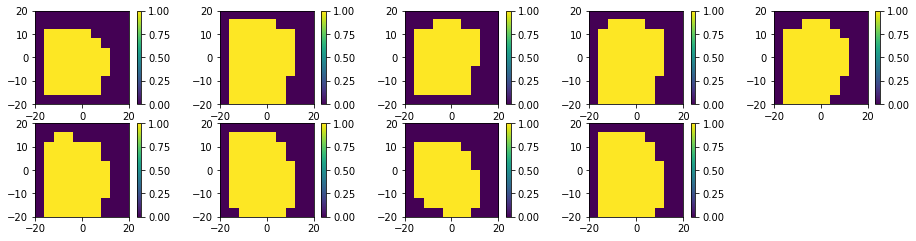

In [12]:
# Plot initial intensity values per bixel and beam
plotFluenceMap(x)

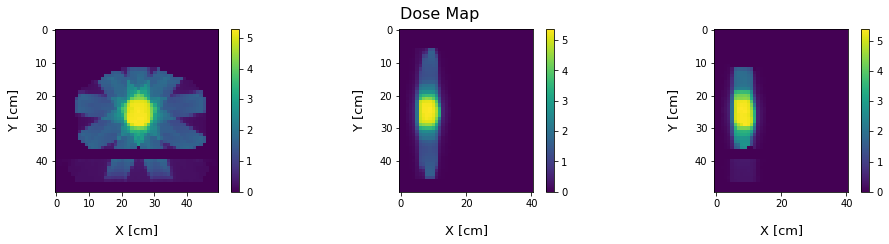

In [13]:
d=Dij[0]*x
plot3DMap(d,"Dose Map")

In [14]:
#for i in range(np.size(objetives,0)):
#    getStructureFromObjetive(objetives[i])[0]
#    if(getStructureFromObjetive(objetives[i])[1]=="TARGET"):
#        dObjetives2=pow(dObjetives(x)[i],2)
#        plot3DMap(dObjetives2,getStructureFromObjetive(objetives[i])[3])

In [15]:
#for i in range(np.size(objetives,0)):
#    if(getStructureFromObjetive(objetives[i])[1]=="OAR"):
#        dObjetives2=pow(dObjetives(x)[i],2)
#        plot3DMap(dObjetives2,getStructureFromObjetive(objetives[i])[3])

In [16]:
print(F(x,0))

499.29430606301145


In [17]:
F_results=[]

In [18]:
# Define gradient of x intensity
for i in range(100):
    x=new_x(x,0)
    F_results.append(F(x,0))
    print(i,F_results[i])

0 435.31605149160964
1 377.8278485796809
2 325.28942863781174
3 279.23962383269236
4 239.38504380842528
5 204.83745416486028
6 175.0891283190356
7 149.65798716222744
8 127.95255438378851
9 109.43393181508732
10 93.64146556358699
11 80.16085447565827
12 68.65436097061563
13 58.85005992155218
14 50.4944463152505
15 43.370090140055105
16 37.2954176306811
17 32.11504998513332
18 27.69443812189713
19 23.920542006337257
20 20.699710446609007
21 17.95030575861712
22 15.60270242408994
23 13.596554869141288
24 11.880532430487017
25 10.41225534670051
26 9.154826470767912
27 8.076913008868615
28 7.152298902864444
29 6.35880195606659
30 5.677679022673783
31 5.092477330658759
32 4.589406191590826
33 4.156608676980882
34 3.7838104385302294
35 3.4611344089181677
36 3.1820460014563507
37 2.940439297507907
38 2.7302071112596673
39 2.5471150686397004
40 2.387059791623946
41 2.246813102266031
42 2.123709950509168
43 2.015168104894728
44 1.9189527422792283
45 1.8334492695831313
46 1.7572923901037298
47 1.

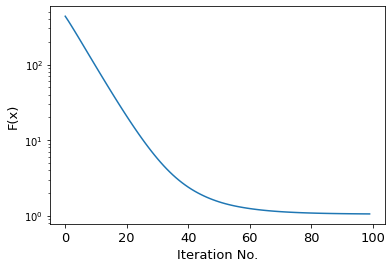

In [19]:
plt.xlabel("Iteration No.", fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("F(x)", fontsize=13)
plt.xticks(fontsize=13)
plt.plot(F_results)
plt.yscale("log")
plt.show()

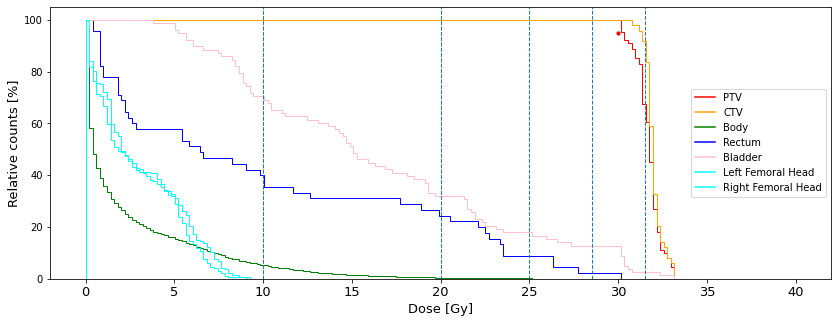

In [20]:
x=normFluence(x,0)
plotDVH(x,[0],["PTV","CTV","Body","Rectum","Bladder","Left Femoral Head","Right Femoral Head"])

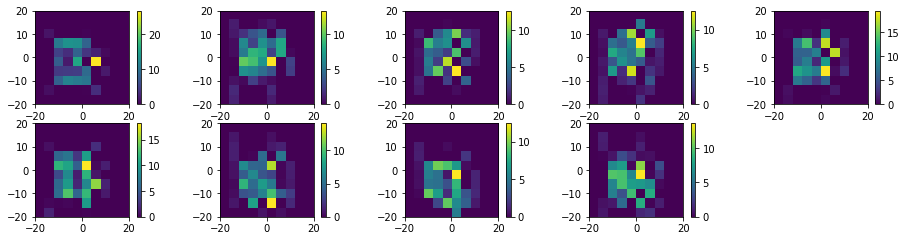

In [21]:
# Plot initial intensity values per bixel and beam
plotFluenceMap(x)

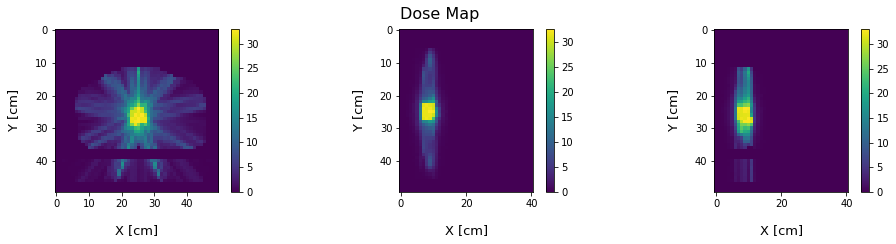

In [22]:
d=Dij[0]*x
plot3DMap(d,"Dose Map")

In [23]:
#for i in range(np.size(objetives,0)):
#    getStructureFromObjetive(objetives[i])[0]
#    if(getStructureFromObjetive(objetives[i])[1]=="TARGET"):
#        dObjetives2=pow(dObjetives(x,0)[i],2)
#        plot3DMap(dObjetives2, getStructureFromObjetive(objetives[i])[3])

In [24]:
#for i in range(np.size(objetives,0)):
#    getStructureFromObjetive(objetives[i])[0]
#    if(getStructureFromObjetive(objetives[i])[1]=="OAR"):
#        dObjetives2=pow(dObjetives(x,0)[i],2)
#        plot3DMap(dObjetives2, getStructureFromObjetive(objetives[i])[3])

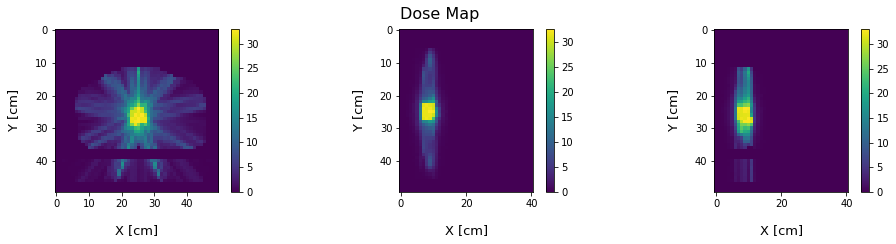

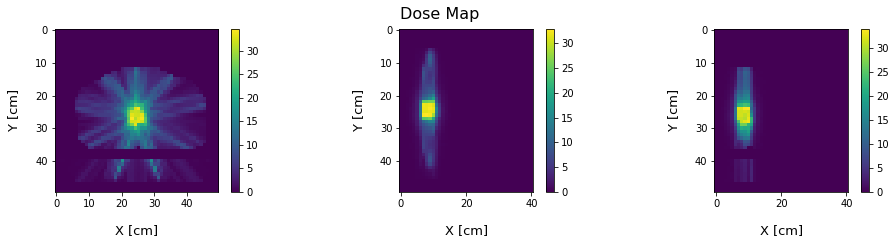

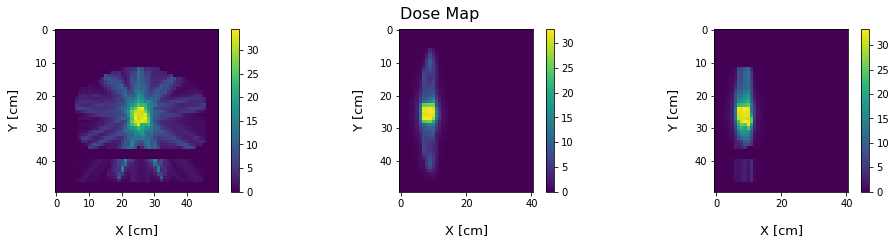

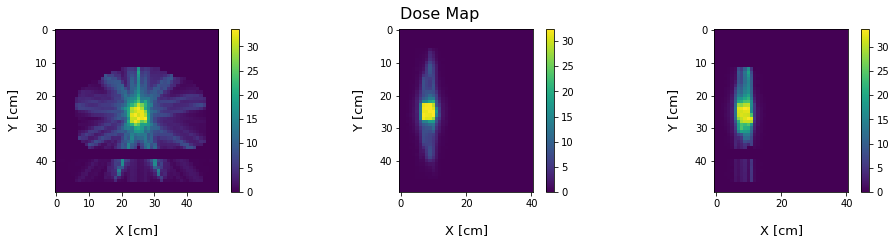

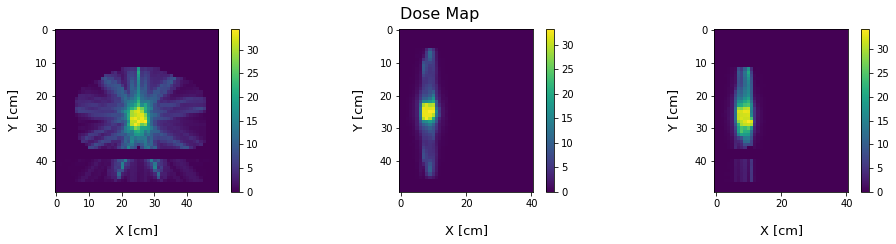

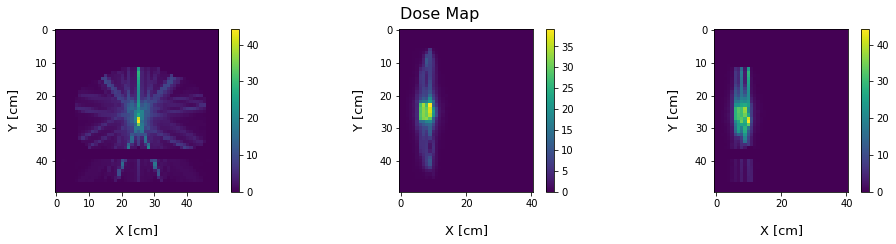

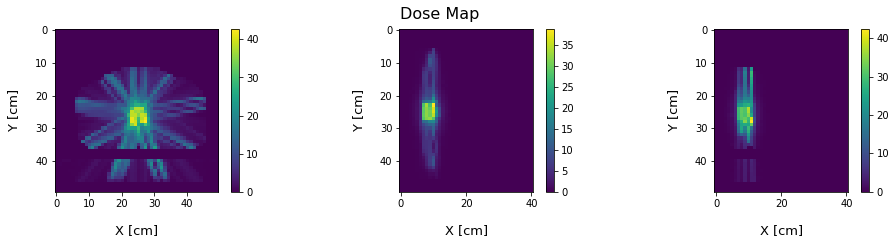

In [25]:
for i in range(np.size(scenarios,0)):
    d=Dij[i]*x
    plot3DMap(d,"Dose Map")

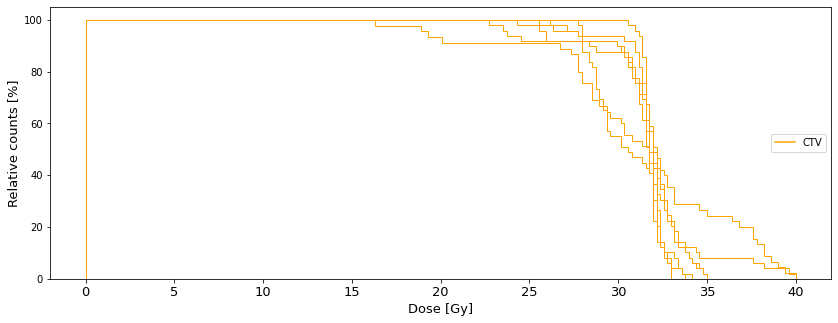

In [26]:
x=normFluence(x,0)
plotDVH(x,[0,1,2,3,4,5,6],["CTV"])

In [36]:
# Initialize intensity vector 
x_robust=np.ones(nBixels).reshape(nBixels,1)
#print(x_robust.shape)

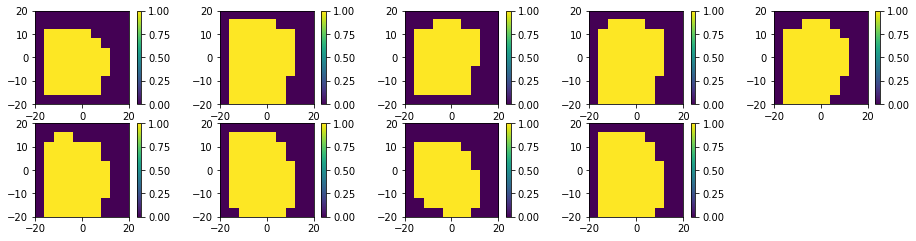

In [37]:
# Plot initial intensity values per bixel and beam
plotFluenceMap(x_robust)

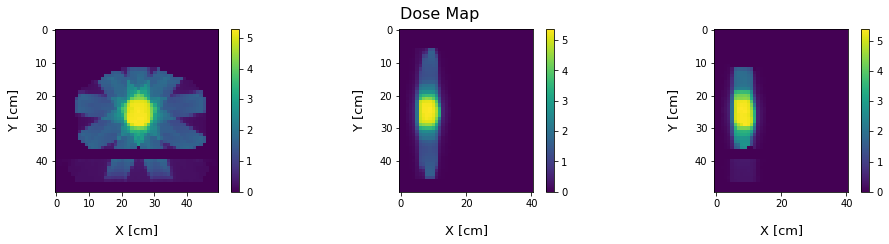

In [38]:
d=Dij[0]*x_robust
plot3DMap(d,"Dose Map")

In [39]:
# Setting PTV objetives and dose prescription
objetives = []
objetives.append([1,"squared_underdosing",28.5,500])
objetives.append([1,"squared_overdosing",31.5,500])
objetives.append([1,"squared_deviation",30,500])
objetives.append([2,"squared_overdosing",25,140])
objetives.append([3,"squared_overdosing",20,80])
objetives.append([4,"squared_overdosing",20,80])
objetives.append([5,"squared_overdosing",10,80])
objetives.append([6,"squared_overdosing",10,80])

In [40]:
print(F_robust(x_robust))

274.3440113599694


In [41]:
# Define gradient of x intensity
F_results=[]
for i in range(100):
    x_robust=new_x_robust(x_robust)
    F_results.append(F_robust(x_robust))
    print(i,F_results[i])

0 240.72861530083193
1 211.3166064996586
2 185.442290939039
3 162.4771471098973
4 142.1645724536829
5 124.34153493580698
6 108.73015614648185
7 95.08686501978562
8 83.17745079965552
9 72.78851276110191
10 63.71274394840026
11 55.79299862149328
12 48.88670744984006
13 42.86371197973799
14 37.61256012913965
15 33.03440199820151
16 29.04182358509575
17 25.559285786640366
18 22.520567297706968
19 19.86842758541862
20 17.553095700507075
21 15.530945938641594
22 13.764238838313803
23 12.220343737909252
24 10.870559012888672
25 9.690030418483856
26 8.656970378655503
27 7.752518424305218
28 6.960200674042708
29 6.2657136160648506
30 5.656576023691818
31 5.121969511874562
32 4.652504095073666
33 4.239784983780748
34 3.8765776606563245
35 3.5565860953297843
36 3.274309786856103
37 3.0249315385768942
38 2.8040027441964646
39 2.6075387447812566
40 2.4322320371849124
41 2.2753030137069166
42 2.134283287452616
43 2.0070829362144367
44 1.8919887924440266
45 1.787579782294772
46 1.69263318478852
47 1.

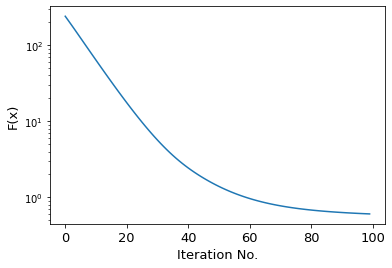

In [42]:
plt.xlabel("Iteration No.", fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("F(x)", fontsize=13)
plt.xticks(fontsize=13)
plt.plot(F_results)
plt.yscale("log")
plt.show()

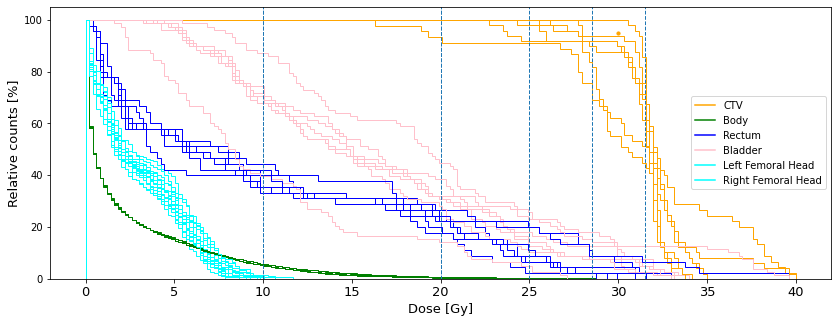

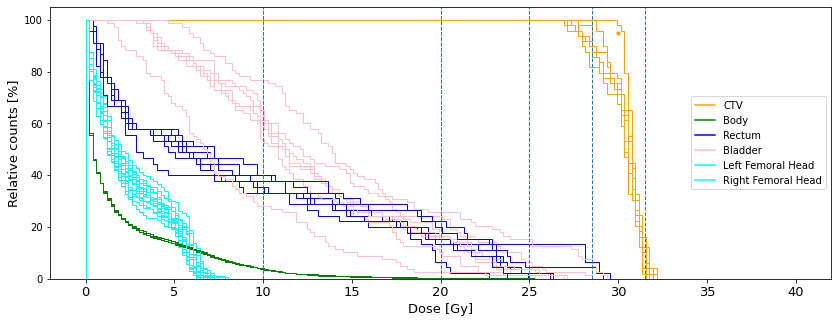

In [43]:
x_robust=normFluence(x_robust,0)
plotDVH(x,[0,1,2,3,4,5,6],["CTV","Body","Rectum","Bladder","Left Femoral Head","Right Femoral Head"])
plotDVH(x_robust,[0,1,2,3,4,5,6],["CTV","Body","Rectum","Bladder","Left Femoral Head","Right Femoral Head"])

In [44]:
d_mean=np.zeros(nVoxels)
d_mean=(Dij[0]*x+Dij[1]*x+Dij[2]*x+Dij[3]*x+Dij[4]*x+Dij[5]*x+Dij[6]*x)/7
d_mean_robust=np.zeros(nVoxels)
d_mean_robust=(Dij[0]*x_robust+Dij[1]*x_robust+Dij[2]*x_robust+Dij[3]*x_robust+Dij[4]*x_robust+Dij[5]*x_robust+Dij[6]*x_robust)/7

In [45]:
d_error=np.zeros(nVoxels)
d_error=pow(Dij[0]*x-d_mean,2)+pow(Dij[1]*x-d_mean,2)+pow(Dij[2]*x-d_mean,2)+pow(Dij[3]*x-d_mean,2)+pow(Dij[4]*x-d_mean,2)+pow(Dij[5]*x-d_mean,2)+pow(Dij[6]*x-d_mean,2)
d_error_robust=np.zeros(nVoxels)
d_error_robust=pow(Dij[0]*x_robust-d_mean_robust,2)+pow(Dij[1]*x_robust-d_mean_robust,2)+pow(Dij[2]*x_robust-d_mean_robust,2)+pow(Dij[3]*x_robust-d_mean_robust,2)+pow(Dij[4]*x_robust-d_mean_robust,2)+pow(Dij[5]*x_robust-d_mean_robust,2)+pow(Dij[6]*x_robust-d_mean_robust,2)



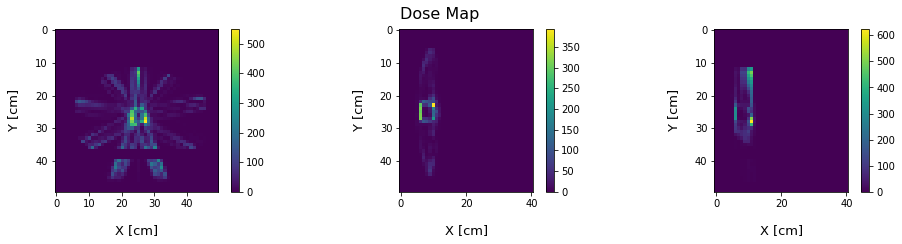

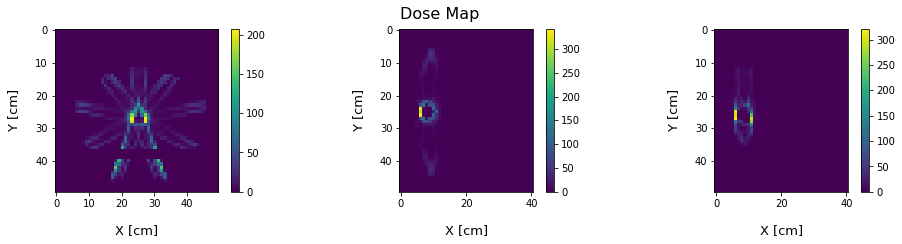

In [47]:
plot3DMap(d_error,"Dose Map")
plot3DMap(d_error_robust,"Dose Map")